<a href="https://colab.research.google.com/github/dfedeoli/btc2020/blob/main/BTCdesafio7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MARATONA BEHIND THE CODE 2020

## DESAFIO 7 - TNT

O mercado de energéticos vem crescendo ano após ano, muito impulsionado por mudanças no hábito de consumo do brasileiro, que antigamente via a bebida energética apenas como um produto de mixologia. Agora, passou a ser um produto de consumo diário devido às suas funcionalidades. Os pontos de vendas (PDV) ganharam então uma atenção ainda maior, pois os produtos precisam estar à disposição do cliente nos momentos que eles necessitam dessas funcionalidades. Como desafio, TNT Energy Drink quer propor uma opção de utilização das *vending machines* como PDV nos momentos que os clientes mais necessitam (Metrôs, Academias, etc.).

Cada *vending machine* servirá como um grande banco de dados fornecendo informações em tempo real de quantidade de produtos, possibilitando o melhor controle de estoque, recomendação de reabastecimentos, melhores pontos de vendas, etc.

Os desenvolvedores deverão utilizar o *IBM Watson Studio* e *IoT* na *IBM Cloud* para criar um modelo preditivo capaz de alertar o momento ideal para recarga de uma máquina de venda automática de TNT. Os participantes deverão se conectar a dispositivos *IoT* para receber os dados de estoque das máquinas em tempo real e ajudar a empresa na reposição, assim as máquinas de venda automática somente serão visitadas quando houver a necessidade de reabastecimento, poupando gastos desnecessários.

Proposição completa do Desafio: https://github.com/maratonadev-br/desafio-7-2020

<hr>

## Importando bibliotecas importantes

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Aquisição de dados via *IoT* (*Broker MQTT*)

A TNT, em conjunto com a organização da Maratona criou um dispotivo IoT que está publicando dados referentes ao seus postos de venda num tópico. Os dados publicados pelo dispotivo IoT formaram a base necessária para construir a segunda parte do desafios. O Dispotivo ficará ligado até o fim da Maratona e basta apenas uma hora para você adquirir todos os dados. Junto dos dados vai vir um indice para saibam quando a base começar a se repetir.

Para adquirir os dados será necessário se conectar ao seguinte endereço por meio do protocolo MQTT com a seguinte configuração:

```
HOST: tnt-iot.maratona.dev
PORT: 30573
USERNAME: maratoners
PASSWORD: ndsjknvkdnvjsbvj
```

A aquisição dos dados foi feita através de uma aplicação em *NODE-RED* e de uma base de dados *Cloudant* na *IBM Cloud*, da mesma forma feita neste [vídeo](https://www.youtube.com/watch?v=yT_DIEu6uzA&feature=youtu.be). Para fazer o download dos dados, é necessário instalar o pacote ``cloudant`` no Jupyter Notebook, da seguinte forma:


In [ ]:
!pip install cloudant

Em seguida, é necessário se conectar à base de dados com o *username* (``u``, ``a``) e *password* (``p``), obtidos nas credenciais de serviço do *Cloudant*.

In [ ]:
from cloudant import Cloudant
u = '5d1547e2-d12d-44a9-93f9-162cfeec78dd-bluemix'
p = '6aed5872fba7370c99c5c195522a1a402824d2d83b2bf4ba0322614ab2383908'
a = '5d1547e2-d12d-44a9-93f9-162cfeec78dd-bluemix'
client = Cloudant(u, p, account=a, connect=True, auto_renew=True)

Para se conectar à base de dados referente aos dados das máquinas de venda automática (no meu caso, ``dfo-iot``):

In [ ]:
db = client['dfo-iot']

Coloca-se então o corpo do documento em forma de matriz, para subsequente transformação em um DataFrame pandas ``df``.

In [ ]:
response = db.all_docs(include_docs=True)

docs = []
for r in response['rows']:
    docs.append(r['doc'])
type(docs)

In [ ]:
df = pd.DataFrame(data=docs)

Removendo colunas referentes à identificação dos dados obtidos dentro do *Cloudant* e excluindo linhas repetidas, obtêm-se o dataset ``dt``.

In [ ]:
df1 = df.drop(['_id','_rev'], axis=1)
dt = df1.drop_duplicates()

O dataset obtido foi então transformado em um arquivo ".csv" e salvo, para que não seja necessária uma nova conexão ao *Cloudant* toda vez que o notebook for reiniciado.

In [ ]:
dt.to_csv('training_dataset_desafio7.csv',index=False)

## Download dos conjuntos de dados em formato .csv

O dataset foi upado para minha página do *GitHub*, facilitando a obtenção dos dados para mim e para quem queira realizar este mesmo projeto de maneira diferente.

Dataset: https://raw.githubusercontent.com/dfedeoli/btc2020/main/training_dataset_desafio7.csv

In [ ]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/dfedeoli/btc2020/main/training_dataset_desafio7.csv
df_data_1 = pd.read_csv(r'training_dataset_desafio7.csv')

--2021-03-05 17:35:17--  https://raw.githubusercontent.com/dfedeoli/btc2020/main/training_dataset_desafio7.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1412464 (1.3M) [text/plain]
Saving to: ‘training_dataset_desafio7.csv’

training_dataset_de 100%[===================>]   1.35M  --.-KB/s    in 0.04s   

2021-03-05 17:35:17 (30.7 MB/s) - ‘training_dataset_desafio7.csv’ saved [1412464/1412464]



É necessário remover a coluna ``row`` do dataset, para deixá-lo no formato pedido na Maratona Behind The Code 2020.

In [ ]:
df_training_dataset = df_data_1.drop(['row'], axis=1)
df_training_dataset.head()

,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
0,2018-1-11,Trianon-Masp,-23.5634,-46.6544,42064,78,65,50,7,4,20,38,2,REABASTECER
1,2018-11-21,Sé,-23.5500,-46.6333,192282,6,41,50,28,5,39,8,43,NORMAL
2,2019-1-22,Sé,-23.5500,-46.6333,192261,52,60,20,21,28,17,38,12,NORMAL
3,2019-7-21,Tamanduateí,-23.5929,-46.5897,50953,42,33,43,37,23,22,43,32,NORMAL
4,2019-8-15,Tamanduateí,-23.5929,-46.5897,51931,75,25,10,29,6,20,43,22,REABASTECER


Através do conjunto de dados ``df_training_dataset``, temos algumas informações gerais sobre os pontos de vendas da TNT:

**Tempo**: data da informação enviada pela *vending machine*;

**Estação**: estação de metrô referente;

**LAT**: latitude;

**LONG**: longitude;

**Movimentação**: número geral de movimentação das máquinas;

**Original_473**: quantidade de TNT Original 473ml disponível;

**Original_269**: quantidade de TNT Original 269ml disponível;

**Zero**: quantidade de TNT Zero disponível;

**Maçã-Verde**: quantidade de TNT Maçã-Verde disponível;

**Tangerina**: quantidade de TNT Tangerina disponível;

**Citrus**: quantidade de TNT Citrus disponível;

**Açaí-Guaraná**: quantidade de TNT Açaí-Guaraná disponível;

**Pêssego**: quantidade de TNT Pêssego disponível;

**TARGET**: se é necessário reabastecer ou não.

In [ ]:
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17014 entries, 0 to 17013
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tempo         17014 non-null  object 
 1   Estação       17014 non-null  object 
 2   LAT           17014 non-null  float64
 3   LONG          17014 non-null  float64
 4   Movimentação  17014 non-null  int64  
 5   Original_473  17014 non-null  int64  
 6   Original_269  17014 non-null  int64  
 7   Zero          17014 non-null  int64  
 8   Maçã-Verde    17014 non-null  int64  
 9   Tangerina     17014 non-null  int64  
 10  Citrus        17014 non-null  int64  
 11  Açaí-Guaraná  17014 non-null  int64  
 12  Pêssego       17014 non-null  int64  
 13  TARGET        17014 non-null  object 
dtypes: float64(2), int64(9), object(3)
memory usage: 1.8+ MB


O dataset não possui dados faltantes, então não será necessário fazer tratamento de dados neste sentido.

In [ ]:
df_training_dataset.nunique()

Tempo             720
Estação            25
LAT                25
LONG               25
Movimentação    14871
Original_473       81
Original_269       65
Zero               63
Maçã-Verde         43
Tangerina          42
Citrus             43
Açaí-Guaraná       42
Pêssego            42
TARGET              2
dtype: int64

<hr>

## Detalhamento do Desafio: classificação binária

Este é um desafio cujo objetivo de negócio é a determinação se uma *vendind machine* precisa ser reabastecida de energético TNT ou não. Para tal, será utilizada uma abordagem de aprendizado de máquina supervisionado (classificação), pois foi disponibilizado um dataset já com "labels", ou em outras palavras, já com exemplos de dados e suas variáveis-alvo. A coluna-alvo neste desafio é a coluna ``TARGET``.

Na biblioteca scikit-learn temos diversos algoritmos para classificação, além da biblioteca xgboost. O participante é livre para utilizar o framework que desejar para completar esse desafio.

<hr>

## Análise prévia do conjunto de dados

Fazendo uma simples análise do conjunto de dados, podemos verificar abaixo, podemos visualizar a distribuição de quantidade restante reportada de cada tipo de TNT. Explicando de maneira simples, os gráficos representam o número de vezes que uma determinada quantidade de TNT foi reportada. Na seguinte célula, é possível visualizar os gráficos dos energéticos: Original 473 ml, Original 269 ml, Zero e Maçã-Verde. A célula subsequente apresenta os dados dos energéticos restantes (Tangerina, Citrus, Açaí-Guaraná e Pêssego).

Gráficos 1 a 4:


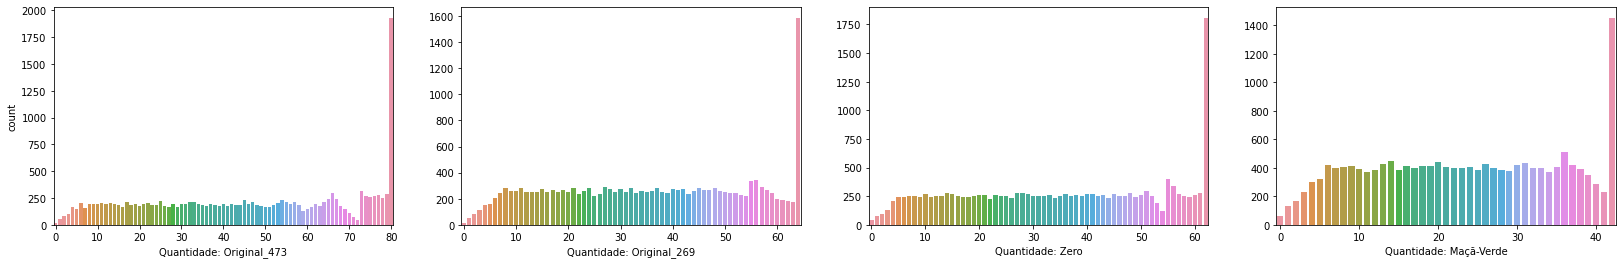

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='Original_473', data=df_training_dataset).set(xticks= np.arange(0,90,10),xlabel='Quantidade: Original_473',ylabel='count')
axes[0].set_xticklabels(np.arange(0,90,10))
sns.countplot(ax=axes[1], x='Original_269', data=df_training_dataset).set(xticks=np.arange(0,65,10),xlabel='Quantidade: Original_269',ylabel='')
axes[1].set_xticklabels(np.arange(0,65,10))
sns.countplot(ax=axes[2], x='Zero', data=df_training_dataset).set(xticks=np.arange(0,65,10),xlabel='Quantidade: Zero',ylabel='')
axes[2].set_xticklabels(np.arange(0,65,10))
sns.countplot(ax=axes[3], x='Maçã-Verde', data=df_training_dataset).set(xticks=np.arange(0,43,10),xlabel='Quantidade: Maçã-Verde',ylabel='')
axes[3].set_xticklabels(np.arange(0,43,10))
print('Gráficos 1 a 4:')

Gráficos 5 a 8:


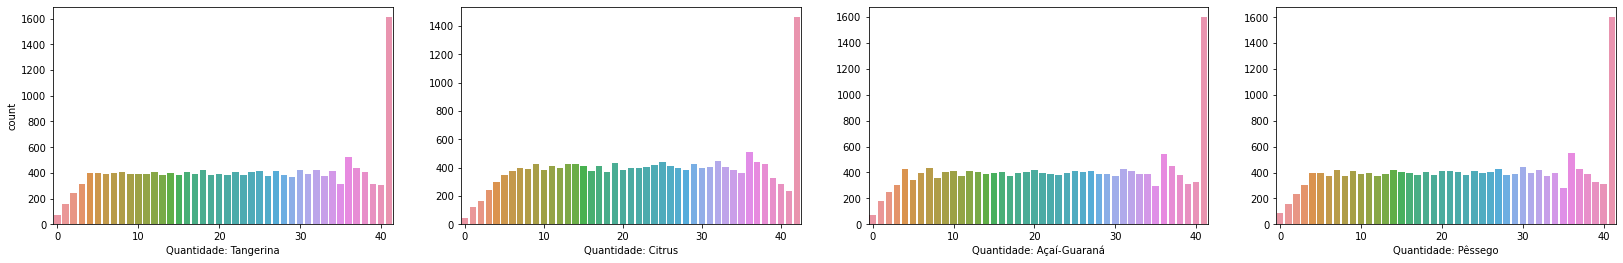

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='Tangerina', data=df_training_dataset).set(xticks=np.arange(0,43,10),xlabel='Quantidade: Tangerina',ylabel='count')
axes[0].set_xticklabels(np.arange(0,43,10))
sns.countplot(ax=axes[1], x='Citrus', data=df_training_dataset).set(xticks=np.arange(0,43,10),xlabel='Quantidade: Citrus',ylabel='')
axes[1].set_xticklabels(np.arange(0,43,10))
sns.countplot(ax=axes[2], x='Açaí-Guaraná', data=df_training_dataset).set(xticks=np.arange(0,43,10),xlabel='Quantidade: Açaí-Guaraná',ylabel='')
axes[2].set_xticklabels(np.arange(0,43,10))
sns.countplot(ax=axes[3], x='Pêssego', data=df_training_dataset).set(xticks=np.arange(0,43,10),xlabel='Quantidade: Pêssego',ylabel='')
axes[3].set_xticklabels(np.arange(0,43,10))
print('Gráficos 5 a 8:')

Em todos os gráficos acima, a quantidade de energético mais vezes reportada representa a quantidade quando o estoque está completo, e o número de vezes que essa quantidade é reportada é muito maior que o restante.

Avaliando a coluna-alvo (``TARGET``) no gráfico abaixo, é possível verificar que o dataset está desbalanceado, e por isso será utilizada a técnica *SMOTE* de balanceamento *over-sampling*.

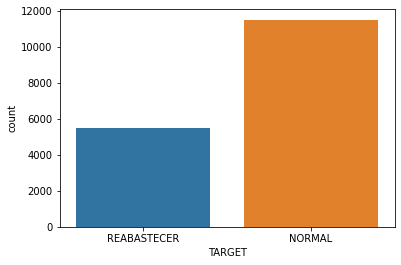

In [ ]:
fig = plt.plot()
sns.countplot(x='TARGET', data=df_training_dataset)

Plotando a matriz de correlação, é possível verificar a relativamente alta correlação entre Latitude, Longitude e movimentação. As coordenadas geográficas servem apenas para localizar a posição da estação de metrô referente.

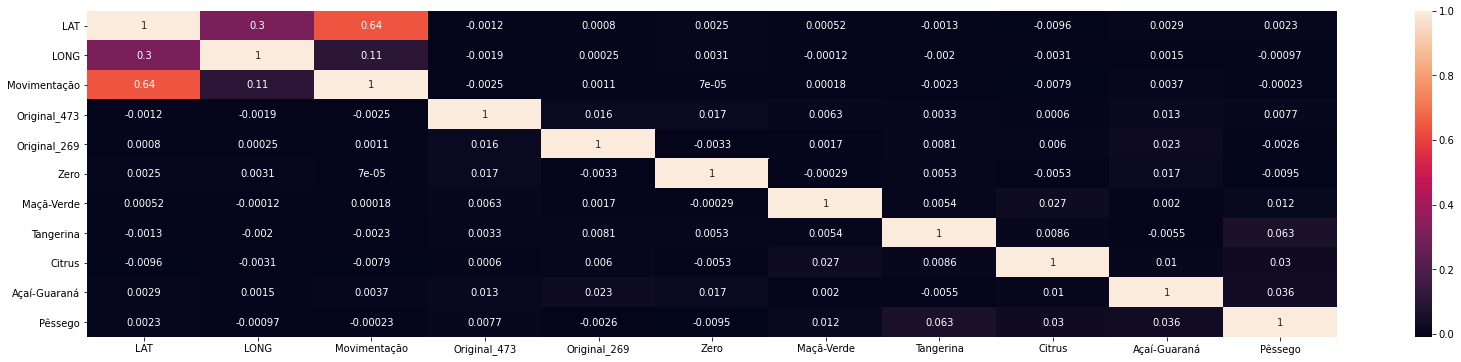

In [ ]:
plt.figure(figsize=(28, 6))
corrMatrix = df_training_dataset.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Pré-processando o dataset antes do treinamento

### Eliminando colunas indesejadas

Vamos **demonstrar** abaixo como usar o método **DataFrame.drop()**.

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

Como a estação de metrô não influencia na questão de reabastecer ou não as *vending machines*, esta coluna será removida. Tendo em vista que, através de ``LAT`` e ``LONG``, ``Movimentação`` tem certa correlação com a estação de metrô, estas três colunas também serão removidas.

In [ ]:
df_training_dataset_rmcolumns = df_training_dataset.drop(columns=['Tempo', 'LAT', 'LONG', 'Movimentação','Estação'], inplace=False)
df_training_dataset_rmcolumns.tail()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
17009,59,35,32,5,22,9,43,2,REABASTECER
17010,23,59,41,14,30,32,5,8,REABASTECER
17011,86,36,31,33,28,4,28,21,REABASTECER
17012,60,48,32,28,43,43,39,26,NORMAL
17013,39,12,21,25,12,4,43,16,NORMAL


### Criando uma nova coluna

Para incrementar o nosso conjunto de dados, será adicionada uma nova coluna através da função abaixo criada, ``SingleDigitValue``. O intuito desta é contar quantos tipos de energético possuem menos de 10 unidades (valores de apenas um dígito, como diz o nome da função) disponíveis na máquina.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class SingleDigitValue(BaseEstimator, TransformerMixin):
    def __init__(self, columns, name):
        self.columns = columns
        self.name = name

    def fit(self, X, y=None):
        return self
      
    def comb(self, data):
        a = 0
        for energ in self.columns:
            if data[energ] <10:
                a += 1                
        return pd.Series([a], index =[f'SINGLE_{self.name}'])
          
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        data = data.join(data.apply(self.comb, axis=1))
        return data

Aplicando esta função ao nosso conjunto de dados para verificar os sabores que possuem menos de 10 unidades disponíveis em cada linha do dataset, obtêm-se o conjunto de dados ``df_training_dataset_sd``, com a nova coluna ``SINGLE_QUANT``. 

In [ ]:
sd = SingleDigitValue(['Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina', 'Citrus',
                       'Açaí-Guaraná', 'Pêssego'], 'QUANT')

df_training_dataset_sd = pd.DataFrame.from_records(sd.fit_transform(df_training_dataset_rmcolumns))
df_training_dataset_sd.tail()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,SINGLE_QUANT
17009,59,35,32,5,22,9,43,2,REABASTECER,3
17010,23,59,41,14,30,32,5,8,REABASTECER,2
17011,86,36,31,33,28,4,28,21,REABASTECER,1
17012,60,48,32,28,43,43,39,26,NORMAL,0
17013,39,12,21,25,12,4,43,16,NORMAL,1


É possível verificar que a função funcionou corretamente, analisando as quantidades disponíveis e o número de opções com menos de uma dezena de unidades.

Abaixo é apresentada a matriz de correlação incluindo esta nova coluna.

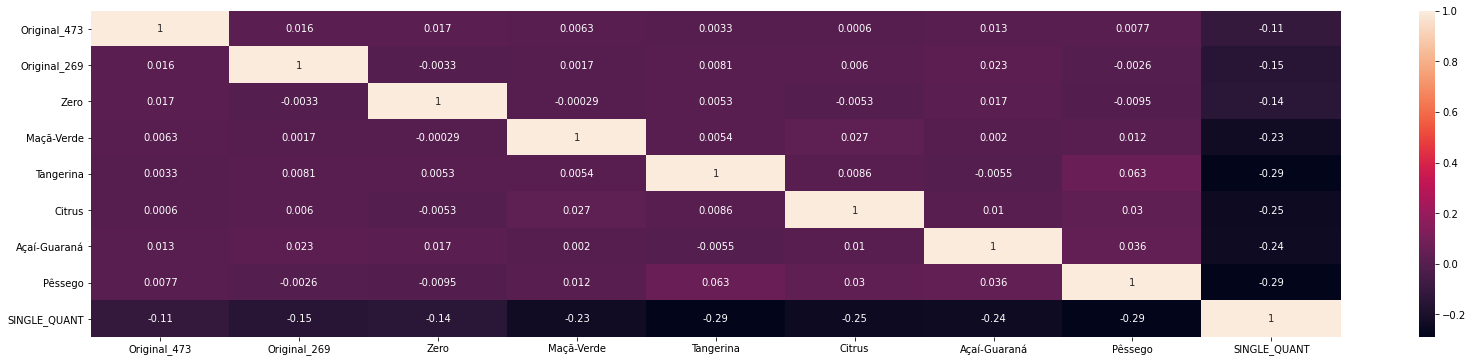

In [ ]:
plt.figure(figsize=(28, 6))
corrMatrix = df_training_dataset_sd.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Treinando um classificador

### Selecionando FEATURES e definindo a variável TARGET

Antes de iniciar o treinamento do modelo de classificação, é necessário dividir as variáveis do dataset entre *features* (variáveis-características) e *target* (variável-alvo).

In [ ]:
df_training_dataset_sd.columns

Index(['Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina',
       'Citrus', 'Açaí-Guaraná', 'Pêssego', 'TARGET', 'SINGLE_QUANT'],
      dtype='object')

In [ ]:
features = df_training_dataset_sd[
    [
       'Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina',
       'Citrus', 'Açaí-Guaraná', 'Pêssego', 'SINGLE_QUANT'
    ]
]
target = df_training_dataset_sd['TARGET']

### Descobrindo o melhor método

Para garantir um modelo otimizado é possível utilizar o ``RandomizedSearchCV``, uma função que permite uma pesquisa randomizada do melhor modelo a ser utilizado, de acordo com uma série de valores definidos pelo usuários para os hiper-parâmetros. Foi escolhida esta função de pesquisa pois não é tão demorada quanto o ``GridSearchCV``, que faz uma busca mais extensa.

Para este desafio, foram testados diversos tipos de modelos de classificação, como regressão logística, árvore de decisão, SVM e redes neurais artificiais. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier

Os parâmetros e valores para a determinação do melhor modelo possível, para cada modelo diferente, são os dispostos na célula seguinte. O único modelo que não está em forma de comentário é o modelo que proporcionou os melhores resultados de acurácia e *F1-Score* mais adiante.

A busca de hiperparâmetros é por 600 iterações, *cross-validation* = 5 (3000 iterações totais) e o valor a ser otimizado é o *F1-Score*.

In [ ]:
params = {
        'learning_rate': [0.15, 0.20, 0.25, 0.3],
        'min_child_weight': [35, 40, 45, 50, 60],
        'gamma': [2, 5, 7.5, 9],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [ 7, 8, 9, 10, 11, 12, 13],
        'n_estimators': [900, 1100, 1200, 1300, 1400],
        'objective': ['binary:logistic', 'reg:logistic','binary:logitraw']
        }

classifier = XGBClassifier()

# params = {
#     'hidden_layer_sizes': [(50,50), (12,12), (25,), (50,)],
#     'activation': ['tanh', 'relu', 'logistic'],
#     'solver': ['sgd', 'adam', 'lbfgs'],
#     'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
#     'learning_rate': ['constant','adaptive', 'invscaling'],
# }

# classifier = MLPClassifier()

# params = {
#     'penalty': ['l1', 'l2'],
#     'solver': ['sag', 'saga', 'lbfgs', 'newton-cg'],
#     'warm_start': [True],
#     'max_iter': [300,500, 700, 1000],
#     'class_weight': ['balanced', None],
#     'random_state': [133]
# }

# classifier = LogisticRegression()

# params = {
#     'penalty': ['l1', 'l2'],
#     'loss': ['hinge', 'squared-hinge'],
#     'C': [1, 0.3,0.1, 0.03, 0.01],
#     'max_iter': [1000, 3000, 5000, 7000],
#     'class_weight': ['balanced', None],
#     'random_state': [133]
# }

# classifier = LinearSVC()

# params = {
#     'penalty': ['l1', 'l2'],
#     'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
#     'alpha': [0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001],
#     'max_iter': [1000, 3000, 5000, 7000],
#     'learning_rate': ['constant', 'optimal', 'invscaling'],
#     'eta0': [0.01, 0.1, 0.03, 0.3],
#     'random_state': [133]
# }

# classifier = SGDClassifier()

# params = {
#     'criterion': ['gini', 'entropy'],
#     'splitter': ['best', 'random'],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'random_state': [133]
# }

# classifier = DecisionTreeClassifier()

random_search_f1 = RandomizedSearchCV(classifier, param_distributions=params, n_iter=600, scoring='f1_weighted', cv=5, verbose=3, n_jobs=-1)

random_search_f1.fit(features, target)

random_search_f1.best_estimator_

print('\n Best estimator:')
print(random_search_f1.best_estimator_)
print('\n Best normalized gini score:')
print(random_search_f1.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search_f1.best_params_)

O melhor modelo encontrado foi um classificador XGBoost, da forma:

```
XGBClassifier(objective='binary:logistic', n_estimators=1100, min_child_weight=40, max_depth=10, learning_rate=0.2, gamma=7.5, colsample_bytree=1.0)
```

utilizado mais à frente para treinamento e predição. A célula acima foi rodada em um notebook diferente, e não será rodada neste pois é um processo demorado.

### Dividindo nosso conjunto de dados em conjuntos de treinamento e teste

Então, é necessário dividir o conjunto de dados em conjunto de treinamento e conjunto de teste:

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

features_np = features.to_numpy()
target_np = target.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(features_np, target_np.ravel(), test_size=0.25, random_state=133)

# Smote
smote = SMOTE(n_jobs=2, random_state=342)
X_train, y_train = smote.fit_resample(X_train, y_train)


Devido ao desbalanceamento do conjunto de dados, foi utilizada a função de balanceamento *SMOTE*, que utiliza técnicas de *over-sampling*. Foram testadas funções de *Tomek Links* e *SMOTE* + *Tomek*, mas o melhor resultado foi obtido por esta forma utilizada.

### Treinando um modelo de predição

Com o modelo definido, inicia-se o treinamento com os dataset ``X_train`` e ``y_train``.

In [ ]:
xgb_model = XGBClassifier(objective='binary:logistic', n_estimators=1100,
                           min_child_weight=40, max_depth=10, learning_rate=0.2, gamma=7.5, colsample_bytree=1.0
                           ).fit(X_train, y_train)

### Fazendo previsões na amostra de teste

Em seguida, é realizada a predição do y utilizando as variáveis ``X_test``.

In [ ]:
y_pred = xgb_model.predict(X_test)
print(y_pred)

['REABASTECER' 'REABASTECER' 'REABASTECER' ... 'NORMAL' 'REABASTECER'
 'NORMAL']


### Analisando a qualidade do modelo através da matriz de confusão

A função abaixo é escrita para a plotagem da matriz de confusão:

In [ ]:
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Comparando os vetores ``y_test`` e ``y_pred``, obtêm-se a matriz de confusão e o relatório de classificação seguintes:

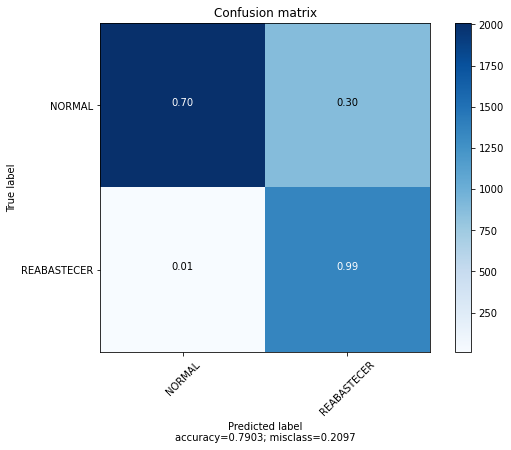

              precision    recall  f1-score   support

      NORMAL       1.00      0.70      0.82      2892
 REABASTECER       0.61      0.99      0.75      1362

    accuracy                           0.79      4254
   macro avg       0.80      0.84      0.79      4254
weighted avg       0.87      0.79      0.80      4254



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['NORMAL', 'REABASTECER'])
print(classification_report(y_test, y_pred))

Pela matriz de confusão, é possível visualizar que 30% dos dados que deveriam ser atribuídos ao valor-alvo ``NORMAL`` foram atribuídos ao valor ``REABASTECER``. De maneira mais simples, isto quer dizer que o modelo acertou praticamente todos os valores reais ``REABASTECER``, mas ele também englobou erroneamente nesta categoria alguns dados que pertenciam à categoria ``NORMAL``.

Porém, no geral, os *F1-Score* tiveram valores satisfatórios (82 e 75%) assim como a acurácia de 79%.

Abaixo é disponibilizada uma tabela com a importância de cada *feature* do modelo de predição treinado, demonstrando a influência proporcionada pela coluna ``SINGLE_QUANT`` no modelo.

In [97]:
feature_importance = xgb_model.feature_importances_

feats = pd.DataFrame(data=feature_importance, index=features.columns)
feats.sort_values(by=0)

,0
Zero,0.034044
Original_269,0.036710
Pêssego,0.039524
Açaí-Guaraná,0.040222
Tangerina,0.067952
Maçã-Verde,0.082872
Citrus,0.087147
Original_473,0.109893
SINGLE_QUANT,0.501636


<hr>

## Scoring dos dados necessários para entregar a solução

Como entrega da solução, espera-se os resultados classificados no seguinte dataset, chamado "to_be_scored.csv":

### Download da "folha de respostas"

In [ ]:
!wget --no-check-certificate --content-disposition https://gitlab.com/JoaoPedroPP/datasets/-/raw/master/ntn/to_be_scored.csv
df_to_be_scored = pd.read_csv('to_be_scored.csv')
df_to_be_scored.tail()

--2021-03-05 18:52:58--  https://gitlab.com/JoaoPedroPP/datasets/-/raw/master/ntn/to_be_scored.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘to_be_scored.csv’

to_be_scored.csv        [ <=>                ]  68.64K  --.-KB/s    in 0.008s  

2021-03-05 18:52:58 (8.32 MB/s) - ‘to_be_scored.csv’ saved [70291]



,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
979,2019-8-19,Hospital São Paulo,-23.5984,-46.6455,26787,34,65,28,17,33,27,6,2
980,2019-8-20,Hospital São Paulo,-23.5984,-46.6455,26629,21,60,18,15,27,22,43,43
981,2019-8-21,Hospital São Paulo,-23.5984,-46.6455,27517,9,56,13,14,21,17,37,37
982,2019-8-22,Hospital São Paulo,-23.5984,-46.6455,26860,86,49,7,14,17,12,33,33
983,2019-8-23,Hospital São Paulo,-23.5984,-46.6455,24571,74,41,65,8,14,7,27,27


O dataframe ``to_be_scored`` é a "folha de respostas". Note que a coluna "TARGET" não existe nessa amostra, que não pode ser então utilizada para treino de modelos de aprendizado supervisionado.

In [ ]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tempo         984 non-null    object 
 1   Estação       984 non-null    object 
 2   LAT           984 non-null    float64
 3   LONG          984 non-null    float64
 4   Movimentação  984 non-null    int64  
 5   Original_473  984 non-null    int64  
 6   Original_269  984 non-null    int64  
 7   Zero          984 non-null    int64  
 8   Maçã-Verde    984 non-null    int64  
 9   Tangerina     984 non-null    int64  
 10  Citrus        984 non-null    int64  
 11  Açaí-Guaraná  984 non-null    int64  
 12  Pêssego       984 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 100.1+ KB



Para poder aplicar o modelo e classificar a folha de respostas, é necessário primeiro aplicar as mesmas transformações com colunas que foram aplicadas no dataset de treino, exceto remover linhas da folha de respostas. Ao final, as 1000 entradas devem estar classificadas, com os valores previstos em uma coluna chamada ``TARGET``.


Na célula abaixo, repetimos rapidamente os mesmos passos de pré-processamento utilizados previamente no modelo de aprendizado de máquina XGBoost.

In [ ]:
# 1 - Remoção de colunas
df_to_be_scored_2 = df_to_be_scored.drop(columns=['Tempo', 'Estação', 'LAT', 'LONG', 'Movimentação'], inplace=False)

# 2 - Quantidade de energéticos com menos de 10 unidades
df_to_be_scored_3 = pd.DataFrame.from_records(sd.fit_transform(df_to_be_scored_2))

df_to_be_scored_3.tail()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,SINGLE_QUANT
979,34,65,28,17,33,27,6,2,2
980,21,60,18,15,27,22,43,43,0
981,9,56,13,14,21,17,37,37,1
982,86,49,7,14,17,12,33,33,1
983,74,41,65,8,14,7,27,27,2


<hr>

Pode ser verificado abaixo que as colunas da folha de resposta agora são idênticas às que foram usadas para treinar o modelo:

In [ ]:
features.columns

Index(['Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina',
       'Citrus', 'Açaí-Guaraná', 'Pêssego', 'SINGLE_QUANT'],
      dtype='object')

In [ ]:
df_to_be_scored_3.columns

Index(['Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina',
       'Citrus', 'Açaí-Guaraná', 'Pêssego', 'SINGLE_QUANT'],
      dtype='object')

Realizando a predição do reabastecimento das máquinas de venda automática, obtêm-se o dataset final com a varíavel ``TARGET`` inclusa.

In [ ]:
y_pred = xgb_model.predict(df_to_be_scored_3.to_numpy())
df_to_be_scored_3['TARGET'] = y_pred
df_to_be_scored_3.tail()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,SINGLE_QUANT,TARGET
979,34,65,28,17,33,27,6,2,2,REABASTECER
980,21,60,18,15,27,22,43,43,0,NORMAL
981,9,56,13,14,21,17,37,37,1,REABASTECER
982,86,49,7,14,17,12,33,33,1,REABASTECER
983,74,41,65,8,14,7,27,27,2,NORMAL


### Salvando a folha de respostas como um arquivo .csv para ser submetido

In [ ]:
df_to_be_scored_3.to_csv("results.csv",index=False)

Pronto! Com uma solução satisfatória, é possível submeter a minha solução para o Desafio 7 da Maratona Behind The Code 2020.